## 7. Experiment design

<br>

So far in our workflow, we have been working forward from a given experimental design and dataset to build up our model and inferences. However, looking back, we can realise that many steps in our workflow actually do not require the collection and use of actual data. Let's recall our workflow from the [introduction](introduction.ipynb):

<br>

<img src="figures/workflow1.png" alt="The workflow!" width="800"/>

<br>

If we have a particular problem in mind, *we don't even need any data* before we can start to utilise a Bayesian workflow. We can build a **generative model** to represent our planned experiment, and use this to produce simulated data, upon which we can **build** and **check** our **statistical model** in a controlled environment. 

Imagine that we have just completed an experiment followed by a Bayesian analysis, and were not able to make strong conclusions regarding our initial question. With all the tools we developed as part of our workflow, we can plan a new and improved experiment that should be able to do so! This kind of approach can be useful in putting together or evaluating research proposals.

<br>

>As the course comes towards an end, I'll also take this opportunity to note that there are many paths through the workflow, and it should *not* be seen as a strict, ordered to-do list. What we have looked at so far is just one path, and the next workflow you attempt may look quite different.   

<br>

We can start by considering a really simple example, like the normal model used to introduce Stan in the [introduction](introduction.ipynb).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as av
import logging

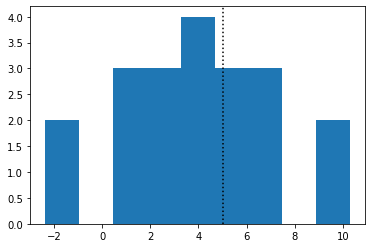

In [2]:
# simulate some data from a normal distribution
N = 20
mu = 5
sigma = 3
x = np.random.normal(mu, sigma, N)

# plot histogram
fig, ax = plt.subplots()
ax.hist(x, bins=np.linspace(min(x), max(x), 10))
ax.axvline(mu, color="k", linestyle=":")

In [3]:
# data for Stan model
data = {}
data["N"] = N
data["x"] = x

# compile and fit
stan_model = CmdStanModel(stan_file="stan/normal.stan")
fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/BayesianWorkflow/src/notebooks/stan/normal
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


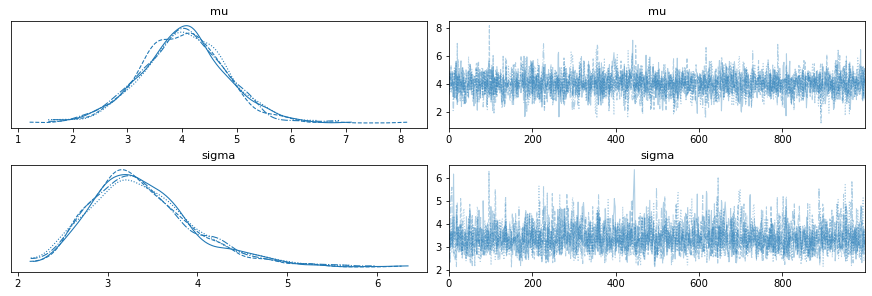

In [4]:
av.plot_trace(fit);

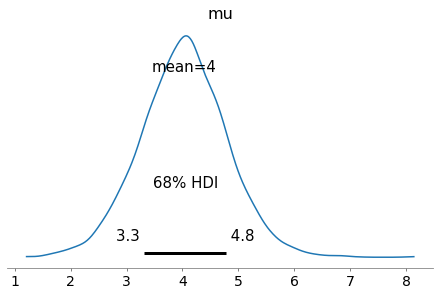

In [5]:
out = av.plot_posterior(fit, hdi_prob=0.68, var_names="mu");

Imagine that the goal for your experiment is to determine the value of $\mu$ to a precision of 0.1 - i.e. the standard deviation of the posterior for $\mu$ should be < 0.1.

In [6]:
np.std(fit.stan_variable("mu"))

0.7756438840295403

It seems our current "experimental setup" with $N=20$ will not be capable of doing this. In this simple demo, there is only really one obvious way we can reduce our uncertainty in the estimate of $\mu$: increasing the number of observations.

We can play around with our simulation to understand roughly how many observations would be needed.

<br>

We could make a plot of the standard deviation of our posterior for $\mu$ as a function of $N$:


In [7]:
# silence logging
logger = logging.getLogger("log")
logger.setLevel(logging.WARNING)
stan_model = CmdStanModel(stan_file="stan/normal.stan", logger=logger)

# run for many N
standard_devs = []
N_vals = np.arange(100, 1500, 5)
for n in N_vals:
    
    # simuate data
    x = np.random.normal(mu, sigma, n)

    # fit data
    data["N"] = n
    data["x"] = x
    fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)
    
    # find std
    standard_devs.append(np.std(fit.stan_variable("mu")))

Text(0, 0.5, 'Width of mu distribution')

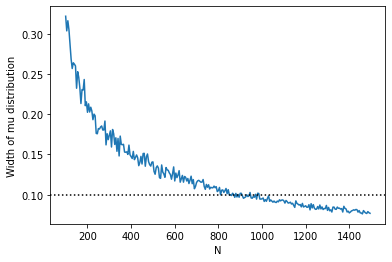

In [8]:
fig, ax = plt.subplots()
ax.plot(N_vals, standard_devs)
ax.axhline(0.1, color="k", linestyle=":")
ax.set_xlabel("N")
ax.set_ylabel("Width of mu distribution")

So we can see that we would probably need something like > 900 observations to constrain the standard deviation of the $\mu$ posterior to < 0.1.

<br>

A few notes on implementing this in practice:

* We skipped our usual sampler checks when running the fit many times, of course we should still include this, and find a way to automate it.
* We can see that the above plot fluctuates depending on the exact simulated realisation at any $N$ value. We could repeat an experiment a number of times at each $N$ to account for this.
* For posteriors that may have non-standard shapes, the highest density interval (HDI) is a  better measure of the width of a distribution.

**Exercise 1 (10 points):** Consider the simple mixture model example from the [model comparison (part1)](model_comparison_part1.ipynb) notebook. We decide that we can conclude signal is present if the tail probability of the marginal posterior, $p(f<0.1)$, is less than 0.01. How many observations are required to achieve this if the true $f=0.5$?

In [9]:
# to be completed...

**Homework exercise 1 (40 points):** Return to the Cepheid variable example and the Hubble constant estimate completed in the [model development](model_development.ipynb) notebook. Investigate what changes could be made to our Cepheid observations to better constrain the Hubble constant. How could we reach a 90\% HDI region of < 10? Make some plots to summarise your results.

In [10]:
# to be completed...